In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.11.3


In [2]:
# CONFIG

df_sensor = pd.read_csv('./data/final_dataset.csv')
df_windows = pd.read_csv('./data/final_window_labels.csv') 

concept_columns = {'periodicity', 'temporal_stability', 'coordination', 'movement_variability', 'movement_consistency'}
discrete_concepts = {'periodicity', 'temporal_stability', 'coordination', 'movement_variability', 'movement_consistency'}

activity_mapping = {act: i for i, act in enumerate(np.unique(df_windows["activity"].values))}

In [3]:
train_idx, test_idx = train_test_split(
    df_windows.index, test_size=0.25, random_state=42, stratify=df_windows['activity']
)

df_windows_train = df_windows.loc[train_idx].reset_index(drop=True)
df_windows_test  = df_windows.loc[test_idx].reset_index(drop=True)

print(df_windows_train.shape)
print(df_windows_test.shape)

(112, 10)
(38, 10)


# Part 1

In the first part we train the base concept predictor model -> this correlates to the `3_sensor_data_to_concepts.ipynb` notebook.
The goal of this is to take the x,y,z accelerometer data and predict the concepts defined.

In [4]:
print(f"Sensor data: {len(df_sensor)} readings")
print(f"Manual labels: {len(df_windows)} windows")

print(f"\nAvailable concepts: {concept_columns}")
print(f"\nConcept distributions:")

for concept in concept_columns:
    if concept not in df_windows.columns:
        print(f"  {concept}: (missing from data)")
        continue

    if concept in discrete_concepts:
        print(f"\n  [Discrete] {concept}:")
        print(df_windows[concept].value_counts(dropna=False))
    else:
        print(f"\n  [Unknown type] {concept}:")
        print(df_windows[concept].head())

Sensor data: 8802 readings
Manual labels: 150 windows

Available concepts: {'periodicity', 'coordination', 'temporal_stability', 'movement_consistency', 'movement_variability'}

Concept distributions:

  [Discrete] periodicity:
periodicity
0.0    90
0.5    35
1.0    25
Name: count, dtype: int64

  [Discrete] coordination:
coordination
1.0    70
0.5    64
0.0    16
Name: count, dtype: int64

  [Discrete] temporal_stability:
temporal_stability
0.5    87
1.0    51
0.0    12
Name: count, dtype: int64

  [Discrete] movement_consistency:
movement_consistency
1.0    92
0.5    47
0.0    11
Name: count, dtype: int64

  [Discrete] movement_variability:
movement_variability
0.5    64
0.0    55
1.0    31
Name: count, dtype: int64


In [5]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 60
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        # Pad with last value if too short
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching for 6 concepts.
    """
    X = []
    y_p = []  # periodicity (classification)
    y_t = []  # temporal_stability (classification)
    y_c = []  # coordination (classification)
    y_mv = [] # movement_variability (classification)
    y_mc = [] # movement_consistency (classification)
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
            # Use new rule-based concepts
            y_mv.append(window_row['movement_variability'])
            y_mc.append(window_row['movement_consistency'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c), np.array(y_mv), np.array(y_mc)

In [6]:
def augment_jitter(data, sigma=0.05):
    """Add random Gaussian noise to simulate sensor imperfections"""
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    """Scale magnitude to simulate different movement intensities"""
    # Handle different data shapes
    if len(data.shape) == 3:
        factor = np.random.normal(1.0, sigma, (data.shape[0], 1, data.shape[2]))
    elif len(data.shape) == 2:
        factor = np.random.normal(1.0, sigma, (data.shape[0], data.shape[1]))
    else:
        factor = np.random.normal(1.0, sigma, data.shape)
    return data * factor

def augment_rotation(data):
    """Rotate 3D data to simulate different phone orientations"""
    angle = np.random.uniform(-np.pi/6, np.pi/6)  # ±30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y_p, y_t, y_c, y_mv, y_mc, factor=10):
    n_original = len(X)
    n_augmented = n_original * factor
    
    # Initialize augmented arrays
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_p_aug = np.zeros(n_augmented)
    y_t_aug = np.zeros(n_augmented)
    y_c_aug = np.zeros(n_augmented)
    y_mv_aug = np.zeros(n_augmented)
    y_mc_aug = np.zeros(n_augmented)
    
    for i in range(n_augmented):
        # Randomly select original sample
        idx = np.random.randint(0, n_original)
        
        # Apply random augmentation
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:  # none
            X_aug[i] = X[idx]
        
        # Copy labels
        y_p_aug[i] = y_p[idx]
        y_t_aug[i] = y_t[idx]
        y_c_aug[i] = y_c[idx]
        y_mv_aug[i] = y_mv[idx]
        y_mc_aug[i] = y_mc[idx]
    
    # Combine original and augmented data
    X_combined = np.vstack([X, X_aug])
    y_p_combined = np.concatenate([y_p, y_p_aug])
    y_t_combined = np.concatenate([y_t, y_t_aug])
    y_c_combined = np.concatenate([y_c, y_c_aug])
    y_mv_combined = np.concatenate([y_mv, y_mv_aug])
    y_mc_combined = np.concatenate([y_mc, y_mc_aug])
    
    return X_combined, y_p_combined, y_t_combined, y_c_combined, y_mv_combined, y_mc_combined

In [7]:
print("Extracting windows for TRAIN set...")
X_train_w, y_p_train_w, y_t_train_w, y_c_train_w, y_mv_train_w, y_mc_train_w = extract_windows_robust(df_sensor, df_windows_train)
print(f"Train windows extracted: {len(X_train_w)}  shape: {X_train_w.shape if len(X_train_w)>0 else None}")

print("Extracting windows for TEST set...")
X_test_w,  y_p_test_w,  y_t_test_w,  y_c_test_w,  y_mv_test_w,  y_mc_test_w  = extract_windows_robust(df_sensor, df_windows_test)
print(f"Test windows extracted: {len(X_test_w)}   shape: {X_test_w.shape if len(X_test_w)>0 else None}")

Extracting windows for TRAIN set...
Train windows extracted: 112  shape: (112, 60, 3)
Extracting windows for TEST set...
Test windows extracted: 38   shape: (38, 60, 3)


In [8]:
print("Augmenting TRAIN data...")
X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug, y_mv_train_aug, y_mc_train_aug = augment_dataset(
    X_train_w, y_p_train_w, y_t_train_w, y_c_train_w, y_mv_train_w, y_mc_train_w, factor=20
)

print(f"Original train: {len(X_train_w)} windows")
print(f"Augmented train: {len(X_train_aug)} windows")

Augmenting TRAIN data...
Original train: 112 windows
Augmented train: 2352 windows


In [9]:
# discrete to categorical
y_p_train_cat = to_categorical(y_p_train_aug * 2, num_classes=3)
y_t_train_cat = to_categorical(y_t_train_aug * 2, num_classes=3)
y_c_train_cat = to_categorical(y_c_train_aug * 2, num_classes=3)
y_mv_train_cat = to_categorical(y_mv_train_aug * 2, num_classes=3)
y_mc_train_cat = to_categorical(y_mc_train_aug * 2, num_classes=3)


y_p_test_cat = to_categorical(y_p_test_w * 2, num_classes=3)
y_t_test_cat = to_categorical(y_t_test_w * 2, num_classes=3)
y_c_test_cat = to_categorical(y_c_test_w * 2, num_classes=3)
y_mv_test_cat = to_categorical(y_mv_test_w * 2, num_classes=3)
y_mc_test_cat = to_categorical(y_mc_test_w * 2, num_classes=3)

print("Labels converted to categorical format (train/test)")

Labels converted to categorical format (train/test)


In [10]:
def build_optimized_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c, n_classes_mv, n_classes_mc):
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dropout(0.4)(x)
    
    # Discrete concepts
    periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
    temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
    coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    movement_variability = layers.Dense(n_classes_mv, activation='softmax', name='movement_variability')(x)
    movement_consistency = layers.Dense(n_classes_mc, activation='softmax', name='movement_consistency')(x)

    
    model = models.Model(inputs=input_layer, outputs=[periodicity, temporal_stability, coordination, movement_variability, movement_consistency])
    
    return model


In [11]:
print("Building model...")
model = build_optimized_cnn(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3, n_classes_mv=3, n_classes_mc=3,
)

# Compile with appropriate loss weights
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'periodicity': 'categorical_crossentropy',
            'temporal_stability': 'categorical_crossentropy',
            'coordination': 'categorical_crossentropy',
            'movement_variability': 'categorical_crossentropy',
            'movement_consistency': 'categorical_crossentropy',
        },
        loss_weights={
            'periodicity': 1.0,
            'temporal_stability': 1.0,
            'coordination': 1.0,
            'movement_variability': 1.0, 
            'movement_consistency': 1.0
        },
        metrics={
            'periodicity': ['accuracy'],
            'temporal_stability': ['accuracy'],
            'coordination': ['accuracy'],
            'movement_variability': ['accuracy'],
            'movement_consistency': ['accuracy'],
        }
    )
    

print(f"Model parameters: {model.count_params():,}")
model.summary()

Building model...
Model parameters: 1,327


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 16)    │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 60, 16)    │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 30, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 16)    │        784 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 16)    │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ periodicity (Dense) │ (None, 3)         │         51 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temporal_stability  │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coordination        │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movement_variabili… │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movement_consisten… │ (None, 3)         │         51 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,327 (5.18 KB)

 Trainable params: 1,263 (4.93 KB)

 Non-trainable params: 64 (256.00 B)

In [12]:
print("Training model...")
history = model.fit(
    X_train_aug,
    [y_p_train_cat, y_t_train_cat, y_c_train_cat, y_mv_train_cat, y_mc_train_cat],
    validation_data=(X_test_w, [y_p_test_cat, y_t_test_cat, y_c_test_cat, y_mv_test_cat, y_mc_test_cat]),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

print("Training completed!")

Training model...
Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - coordination_accuracy: 0.4264 - coordination_loss: 1.0951 - loss: 5.0292 - movement_consistency_accuracy: 0.5561 - movement_consistency_loss: 0.9984 - movement_variability_accuracy: 0.6433 - movement_variability_loss: 0.8367 - periodicity_accuracy: 0.4809 - periodicity_loss: 1.0276 - temporal_stability_accuracy: 0.4872 - temporal_stability_loss: 1.0702 - val_coordination_accuracy: 0.6053 - val_coordination_loss: 0.8506 - val_loss: 4.9949 - val_movement_consistency_accuracy: 0.7368 - val_movement_consistency_loss: 0.8242 - val_movement_variability_accuracy: 0.7368 - val_movement_variability_loss: 0.8357 - val_periodicity_accuracy: 0.3947 - val_periodicity_loss: 1.3534 - val_temporal_stability_accuracy: 0.7105 - val_temporal_stability_loss: 0.8482 - learning_rate: 0.0010
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - coordination_accuracy: 0.5761 - coordination_loss: 0.8768 - loss: 4.0278 - movement_consistenc

In [13]:
def calculate_auroc_multi_output(y_true_categorical, y_pred_proba, concept_name, num_classes):
    """
    Calculate AUROC for multi-output CNN concepts
    
    Args:
        y_true_categorical: True labels in categorical format
        y_pred_proba: Predicted probabilities from model
        concept_name: Name of the concept (for discrete concepts only)
        num_classes: Number of classes for this concept
    
    Returns:
        AUROC score
    """
    # Convert categorical to integer labels
    y_true = np.argmax(y_true_categorical, axis=1)
    
    # For binary classification (2 classes)
    if num_classes == 2:
        # Use the probability of the positive class
        y_scores = y_pred_proba[:, 1]
        return roc_auc_score(y_true, y_scores)
    else:
        # Binarize the labels for multi-class AUROC calculation
        y_true_bin = label_binarize(y_true, classes=range(num_classes))
        
        if y_true_bin.shape[1] == 1:
            # Binary case
            return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
        else:
            # Multi-class case
            return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')

In [17]:
y_test_map = {
    'periodicity': y_p_test_cat,
    'temporal_stability': y_t_test_cat,
    'coordination': y_c_test_cat,
    'movement_variability': y_mv_test_cat,
    'movement_consistency': y_mc_test_cat,
}

print("Evaluating model...")
results = model.evaluate(X_test_w, list(y_test_map.values()), verbose=0)

predictions = model.predict(X_test_w, verbose=0)
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
movement_variability_pred = np.argmax(predictions[3], axis=1)
movement_consistency_pred = np.argmax(predictions[4], axis=1)

periodicity_acc = accuracy_score(np.argmax(y_p_test_cat, axis=1), periodicity_pred)
temporal_stability_acc = accuracy_score(np.argmax(y_t_test_cat, axis=1), temporal_stability_pred)
coordination_acc = accuracy_score(np.argmax(y_c_test_cat, axis=1), coordination_pred)
movement_variability_acc = accuracy_score(np.argmax(y_mv_test_cat, axis=1), movement_variability_pred)
movement_consistency_acc = accuracy_score(np.argmax(y_mc_test_cat, axis=1), movement_consistency_pred)

periodicity_auroc = calculate_auroc_multi_output(y_p_test_cat, predictions[0], 'periodicity', 3)
temporal_stability_auroc = calculate_auroc_multi_output(y_t_test_cat, predictions[1], 'temporal_stability', 3)
coordination_auroc = calculate_auroc_multi_output(y_c_test_cat, predictions[2], 'coordination', 3)
movement_variability_auroc = calculate_auroc_multi_output(y_mv_test_cat, predictions[3], 'movement_variability', 3)
movement_consistency_auroc = calculate_auroc_multi_output(y_mc_test_cat, predictions[4], 'movement_consistency', 3)

overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc + movement_variability_acc + movement_consistency_acc) / 5.0

auroc_scores = [periodicity_auroc, temporal_stability_auroc, coordination_auroc, movement_variability_auroc, movement_consistency_auroc]
valid_auroc_scores = [score for score in auroc_scores if not np.isnan(score)]
overall_auroc = np.mean(valid_auroc_scores) if valid_auroc_scores else 0.5

print(f"\n=== RESULTS ===")
print(f"\n--- Classification Concepts (Discrete) ---")
print(f"Periodicity - Accuracy: {periodicity_acc:.4f}, AUROC: {periodicity_auroc:.4f}")
print(f"Temporal Stability - Accuracy: {temporal_stability_acc:.4f}, AUROC: {temporal_stability_auroc:.4f}")
print(f"Coordination - Accuracy: {coordination_acc:.4f}, AUROC: {coordination_auroc:.4f}")
print(f"Movement Variability - Accuracy: {movement_variability_acc:.4f}, AUROC: {movement_variability_auroc:.4f}")
print(f"Movement Consistency - Accuracy: {movement_consistency_acc:.4f}, AUROC: {movement_consistency_auroc:.4f}")

print(f"\n--- Overall Performance ---")
print(f"Overall Average Accuracy (classification concepts): {overall_acc*100:.1f}%")
print(f"Overall Average AUROC (classification concepts): {overall_auroc:.4f}")

Evaluating model...

=== RESULTS ===

--- Classification Concepts (Discrete) ---
Periodicity - Accuracy: 0.7105, AUROC: 0.8621
Temporal Stability - Accuracy: 0.7368, AUROC: 0.8666
Coordination - Accuracy: 0.6842, AUROC: 0.7655
Movement Variability - Accuracy: 0.9474, AUROC: 0.9918
Movement Consistency - Accuracy: 0.6842, AUROC: 0.8232

--- Overall Performance ---
Overall Average Accuracy (classification concepts): 75.3%
Overall Average AUROC (classification concepts): 0.8618


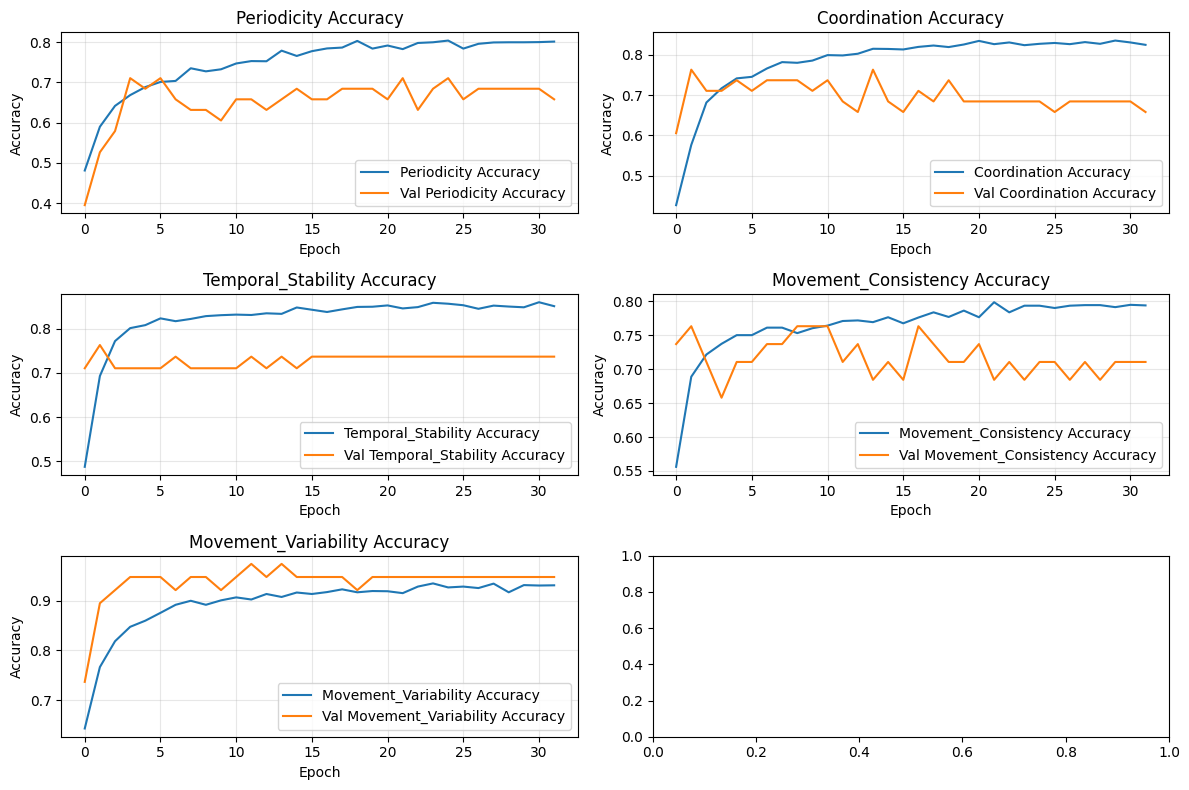

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i, concept in enumerate(discrete_concepts):
    row, col = i // 2, i % 2
    axes[row, col].plot(history.history[f'{concept}_accuracy'], label=f'{concept.title()} Accuracy')
    axes[row, col].plot(history.history[f'val_{concept}_accuracy'], label=f'Val {concept.title()} Accuracy')
    axes[row, col].set_title(f'{concept.title()} Accuracy')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Part 2

This part corresponds to the `4_concept_to_true_labels.ipynb`. The goal of this part is to build a model, in this case we chose to use a LogisicRegression model as that yielded the best results. The analysis of the different models can be seen in the 4th notebook.

In [21]:
def calculate_auroc(y_true, y_pred_proba, num_classes):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    
    if y_true_bin.shape[1] == 1:
        return roc_auc_score(y_true_bin, y_pred_proba[:, 1])
    else:
        return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')

In [22]:
X_final_train = df_windows_train[list(concept_columns)].values
X_final_test  = df_windows_test[list(concept_columns)].values

y_train = np.array([activity_mapping[act] for act in df_windows_train['activity'].values])
y_test  = np.array([activity_mapping[act] for act in df_windows_test['activity'].values])

num_classes = len(activity_mapping)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_final_train, y_train)

y_pred_lr = lr.predict(X_final_test)
y_pred_proba_lr = lr.predict_proba(X_final_test)

print("=== Logistic Regression (trained on GT concepts from TRAIN split) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("AUROC:", calculate_auroc(y_test, y_pred_proba_lr, num_classes))
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

=== Logistic Regression (trained on GT concepts from TRAIN split) ===
Accuracy: 0.5789473684210527
AUROC: 0.8958293330773172
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.75      0.86      0.80         7
           2       0.62      0.83      0.71         6
           3       0.75      0.50      0.60         6
           4       0.30      0.50      0.38         6
           5       0.71      0.71      0.71         7

    accuracy                           0.58        38
   macro avg       0.52      0.57      0.53        38
weighted avg       0.53      0.58      0.55        38

[[0 0 0 0 5 1]
 [0 6 0 0 1 0]
 [0 0 5 1 0 0]
 [0 0 3 3 0 0]
 [1 1 0 0 3 1]
 [0 1 0 0 1 5]]


# Part 3

The goal of this part is to combine the two previous parts together and see the full CBM in action, while also displaying the proper visualizations.

In [23]:

concept_order = ['periodicity', 'temporal_stability', 'coordination', 'movement_variability', 'movement_consistency']

X_test_filtered = []
y_test_aligned = []
X_final_test_aligned = []
rows_filtered = []

for _, row in df_windows_test.iterrows():
    wd = extract_window_robust(df_sensor, row)
    if wd is not None:
        X_test_filtered.append(wd)
        y_test_aligned.append(activity_mapping[row['activity']])
        X_final_test_aligned.append([row[col] for col in concept_order])
        rows_filtered.append(row)

if len(X_test_filtered) == 0:
    print("No test windows available after extraction. This shouldn't happen. Something broke in testing pipeline.")
    raise SystemExit

X_test_filtered = np.array(X_test_filtered)
y_test_aligned = np.array(y_test_aligned)
X_final_test_aligned = np.array(X_final_test_aligned)

print(f"\n=== CNN Results ===")

predictions = model.predict(X_test_filtered, verbose=0)

# discrete predictions
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
movement_variability_pred = np.argmax(predictions[3], axis=1)
movement_consistency_pred = np.argmax(predictions[4], axis=1)

# Get ground truth labels for comparison
y_p_gt = np.array([int(row['periodicity'] * 2) for row in rows_filtered])
y_t_gt = np.array([int(row['temporal_stability'] * 2) for row in rows_filtered])
y_c_gt = np.array([int(row['coordination'] * 2) for row in rows_filtered])
y_mv_gt = np.array([int(row['movement_variability'] * 2) for row in rows_filtered])
y_mc_gt = np.array([int(row['movement_consistency'] * 2) for row in rows_filtered])

# Calculate accuracies for discrete concepts
periodicity_acc = accuracy_score(y_p_gt, periodicity_pred)
temporal_stability_acc = accuracy_score(y_t_gt, temporal_stability_pred)
coordination_acc = accuracy_score(y_c_gt, coordination_pred)
movement_variability_acc = accuracy_score(y_mv_gt, movement_variability_pred)
movement_consistency_acc = accuracy_score(y_mc_gt, movement_consistency_pred)

periodicity_auroc = calculate_auroc_multi_output(
    to_categorical(y_p_gt, num_classes=3), predictions[0], 'periodicity', 3
)
temporal_stability_auroc = calculate_auroc_multi_output(
    to_categorical(y_t_gt, num_classes=3), predictions[1], 'temporal_stability', 3
)
coordination_auroc = calculate_auroc_multi_output(
    to_categorical(y_c_gt, num_classes=3), predictions[2], 'coordination', 3
)
movement_variability_auroc = calculate_auroc_multi_output(
    to_categorical(y_mv_gt, num_classes=3), predictions[3], 'movement_variability', 3
)
movement_consistency_auroc = calculate_auroc_multi_output(
    to_categorical(y_mc_gt, num_classes=3), predictions[4], 'movement_consistency', 3
)

overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc + movement_variability_acc + movement_consistency_acc) / 5.0

auroc_scores = [periodicity_auroc, temporal_stability_auroc, coordination_auroc, movement_variability_auroc, movement_consistency_auroc]
valid_auroc_scores = [score for score in auroc_scores if not np.isnan(score)]
overall_auroc = np.mean(valid_auroc_scores) if valid_auroc_scores else 0.5

print(f"\nClassification Concepts (Discrete)")
print(f"Periodicity - Accuracy: {periodicity_acc:.4f}, AUROC: {periodicity_auroc:.4f}")
print(f"Temporal Stability - Accuracy: {temporal_stability_acc:.4f}, AUROC: {temporal_stability_auroc:.4f}")
print(f"Coordination - Accuracy: {coordination_acc:.4f}, AUROC: {coordination_auroc:.4f}")
print(f"Movement Variability - Accuracy: {movement_variability_acc:.4f}, AUROC: {movement_variability_auroc:.4f}")
print(f"Movement Consistency - Accuracy: {movement_consistency_acc:.4f}, AUROC: {movement_consistency_auroc:.4f}")

print(f"\nOverall Performance")
print(f"Overall Average Accuracy (classification concepts): {overall_acc*100:.1f}%")
print(f"Overall Average AUROC (classification concepts): {overall_auroc:.4f}")

print(f"\n=== LOGISTIC REGRESSION ===")

X_final_test_original = df_windows_test[list(concept_columns)].values
y_test_original = np.array([activity_mapping[act] for act in df_windows_test['activity'].values])

X_final_test_aligned_corrected = df_windows_test[list(concept_columns)].values

y_pred_lr_gt_filtered = lr.predict(X_final_test_aligned_corrected)
y_pred_proba_lr_gt_filtered = lr.predict_proba(X_final_test_aligned_corrected)

print("\nLR performance (ground truth concepts to activity labels)")
print("Accuracy:", accuracy_score(y_test_original, y_pred_lr_gt_filtered))
print("AUROC:", calculate_auroc(y_test_original, y_pred_proba_lr_gt_filtered, num_classes))

concept_columns_list = list(concept_columns)
concept_order_to_training = [concept_order.index(col) for col in concept_columns_list]
predicted_concepts_ordered = np.column_stack([
    periodicity_pred / 2.0,
    temporal_stability_pred / 2.0,
    coordination_pred / 2.0,
    movement_variability_pred / 2.0,
    movement_consistency_pred / 2.0,
])

predicted_concepts_matrix = predicted_concepts_ordered[:, concept_order_to_training]

y_pred_lr_cnn = lr.predict(predicted_concepts_matrix)
y_pred_proba_lr_cnn = lr.predict_proba(predicted_concepts_matrix)

print("\n=== FULL CBM STATS x,y,z -> concepts -> activity label ===")
print("Accuracy:", accuracy_score(y_test_original, y_pred_lr_cnn))
print("AUROC:", calculate_auroc(y_test_original, y_pred_proba_lr_cnn, num_classes))


=== CNN Results ===

Classification Concepts (Discrete)
Periodicity - Accuracy: 0.7368, AUROC: 0.8407
Temporal Stability - Accuracy: 0.7368, AUROC: 0.8957
Coordination - Accuracy: 0.7105, AUROC: 0.7880
Movement Variability - Accuracy: 0.9474, AUROC: 0.9908
Movement Consistency - Accuracy: 0.7105, AUROC: 0.7878

Overall Performance
Overall Average Accuracy (classification concepts): 76.8%
Overall Average AUROC (classification concepts): 0.8606

=== LOGISTIC REGRESSION ===

LR performance (ground truth concepts to activity labels)
Accuracy: 0.5789473684210527
AUROC: 0.8958293330773172

=== FULL CBM STATS x,y,z -> concepts -> activity label ===
Accuracy: 0.5263157894736842
AUROC: 0.8382656490015362


In [24]:
X_final_test_original = df_windows_test[list(concept_columns)].values
y_test_original = np.array([activity_mapping[act] for act in df_windows_test['activity'].values])

y_pred_lr_gt_original = lr.predict(X_final_test_original)
y_pred_proba_lr_gt_original = lr.predict_proba(X_final_test_original)

concept_columns_list = list(concept_columns)
concept_order_to_training = [concept_order.index(col) for col in concept_columns_list]

predicted_concepts_ordered = np.column_stack([
    periodicity_pred / 2.0,
    temporal_stability_pred / 2.0,
    coordination_pred / 2.0,
    movement_variability_pred / 2.0,
    movement_consistency_pred / 2.0,
])

predicted_concepts_matrix = predicted_concepts_ordered[:, concept_order_to_training]

y_pred_lr_cnn = lr.predict(predicted_concepts_matrix)
y_pred_proba_lr_cnn = lr.predict_proba(predicted_concepts_matrix)

WINDOW 1/5
User: 7
Time: 133.5s - 136.5s
Activity: Upstairs (Ground Truth)

GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 0.5
   Coordination: 1.0
   Movement Variability: 0.5000
   Movement Consistency: 1.0000

CNN PREDICTED CONCEPTS:
   Periodicity: 0.0 (confidence: 0.455)
   Temporal Stability: 0.5 (confidence: 0.932)
   Coordination: 0.5 (confidence: 0.695)
   Movement Variability: 0.5 (confidence: 0.922)
   Movement Consistency: 0.5 (confidence: 0.495)
LOGISTIC REGRESSION PREDICTIONS:
   Correct label for this window: Upstairs
   CNN→LR: Downstairs (confidence: 0.342)
   GT→LR: Upstairs (confidence: 0.276)

TOP 3 ACTIVITY CLOSEST ACTIVITIES:
   1. Downstairs: 0.342
   2. Upstairs: 0.216
   3. Walking: 0.171


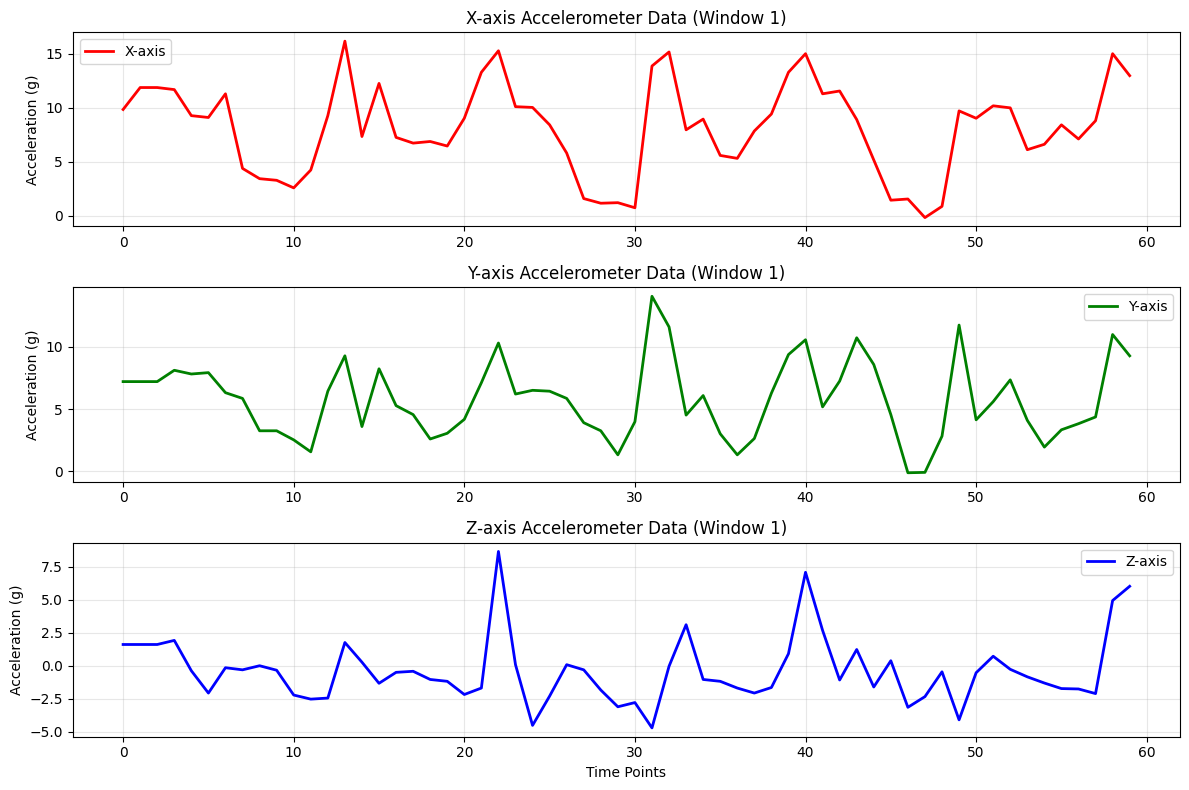

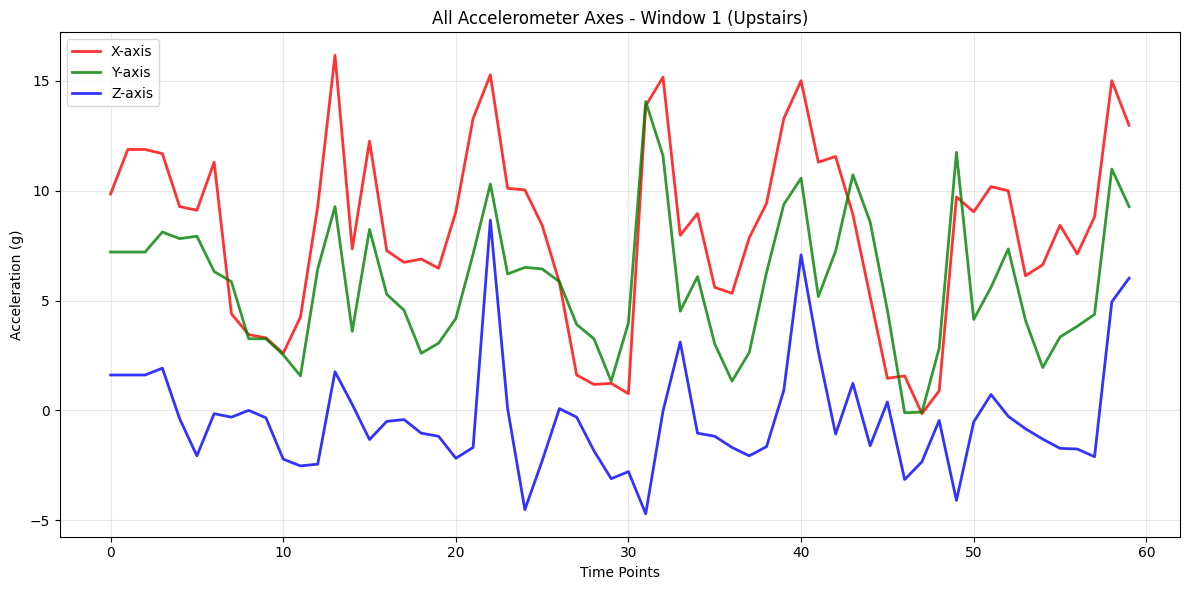

WINDOW 2/5
User: 6
Time: 5.2s - 8.2s
Activity: Standing (Ground Truth)

GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 0.5
   Coordination: 1.0
   Movement Variability: 0.0000
   Movement Consistency: 0.5000

CNN PREDICTED CONCEPTS:
   Periodicity: 0.0 (confidence: 0.922)
   Temporal Stability: 0.5 (confidence: 0.681)
   Coordination: 0.0 (confidence: 0.579)
   Movement Variability: 0.0 (confidence: 0.530)
   Movement Consistency: 1.0 (confidence: 0.779)
LOGISTIC REGRESSION PREDICTIONS:
   Correct label for this window: Standing
   CNN→LR: Upstairs (confidence: 0.417)
   GT→LR: Standing (confidence: 0.375)

TOP 3 ACTIVITY CLOSEST ACTIVITIES:
   1. Upstairs: 0.417
   2. Walking: 0.231
   3. Downstairs: 0.225


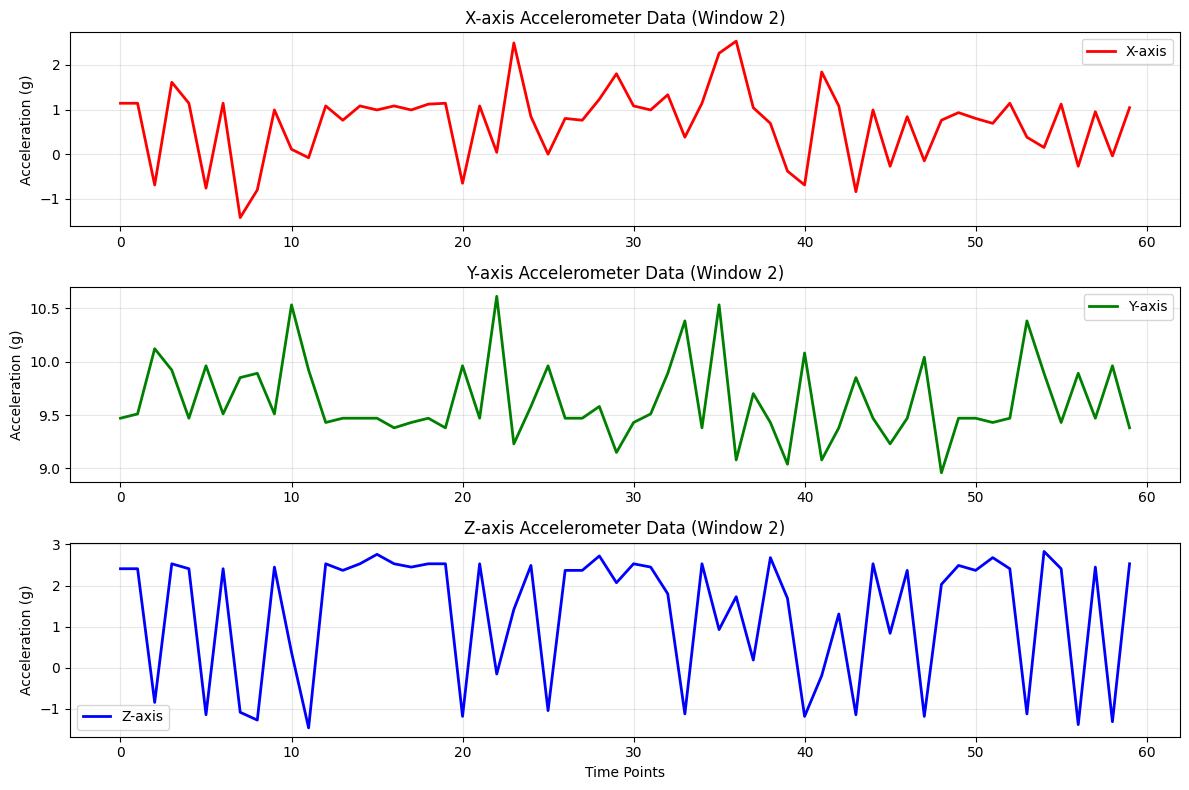

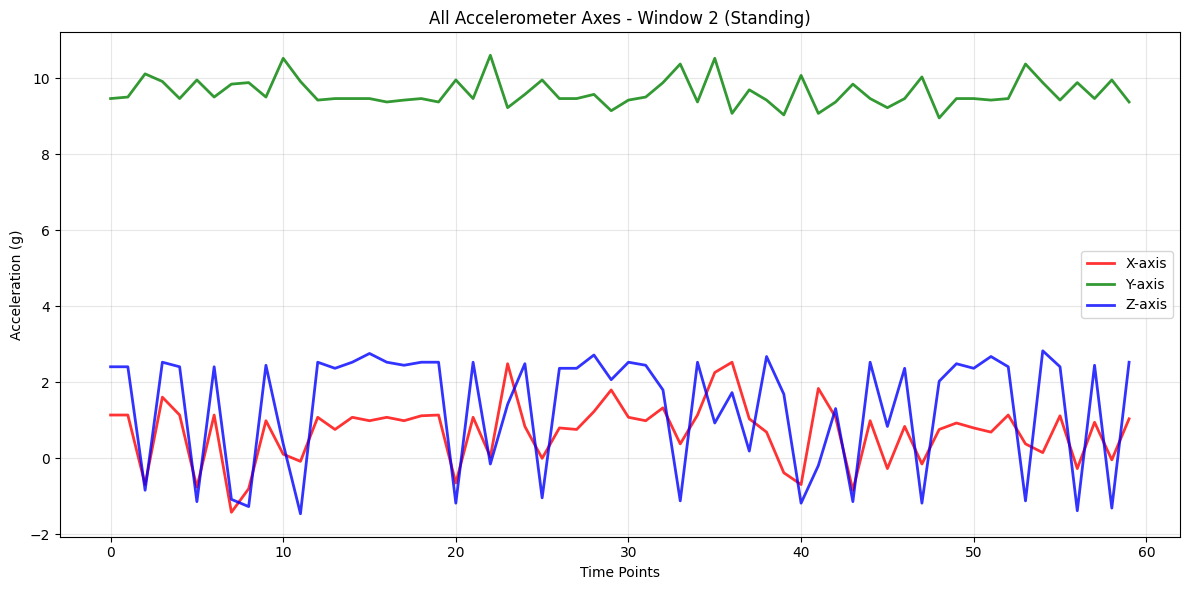

WINDOW 3/5
User: 6
Time: 11.2s - 14.2s
Activity: Sitting (Ground Truth)

GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 1.0
   Coordination: 1.0
   Movement Variability: 0.0000
   Movement Consistency: 0.5000

CNN PREDICTED CONCEPTS:
   Periodicity: 0.0 (confidence: 0.991)
   Temporal Stability: 1.0 (confidence: 0.955)
   Coordination: 1.0 (confidence: 0.989)
   Movement Variability: 0.0 (confidence: 1.000)
   Movement Consistency: 0.5 (confidence: 0.761)
LOGISTIC REGRESSION PREDICTIONS:
   Correct label for this window: Sitting
   CNN→LR: Sitting (confidence: 0.426)
   GT→LR: Sitting (confidence: 0.426)

TOP 3 ACTIVITY CLOSEST ACTIVITIES:
   1. Sitting: 0.426
   2. Standing: 0.418
   3. Downstairs: 0.067


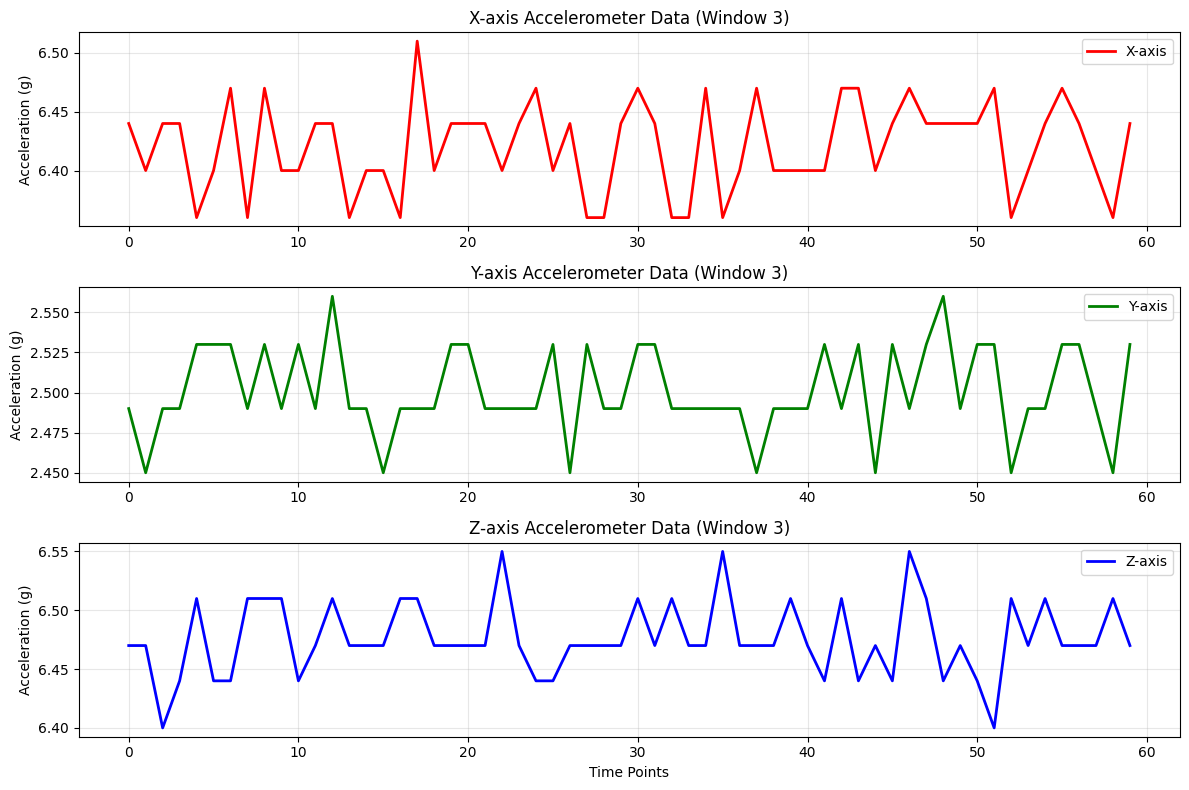

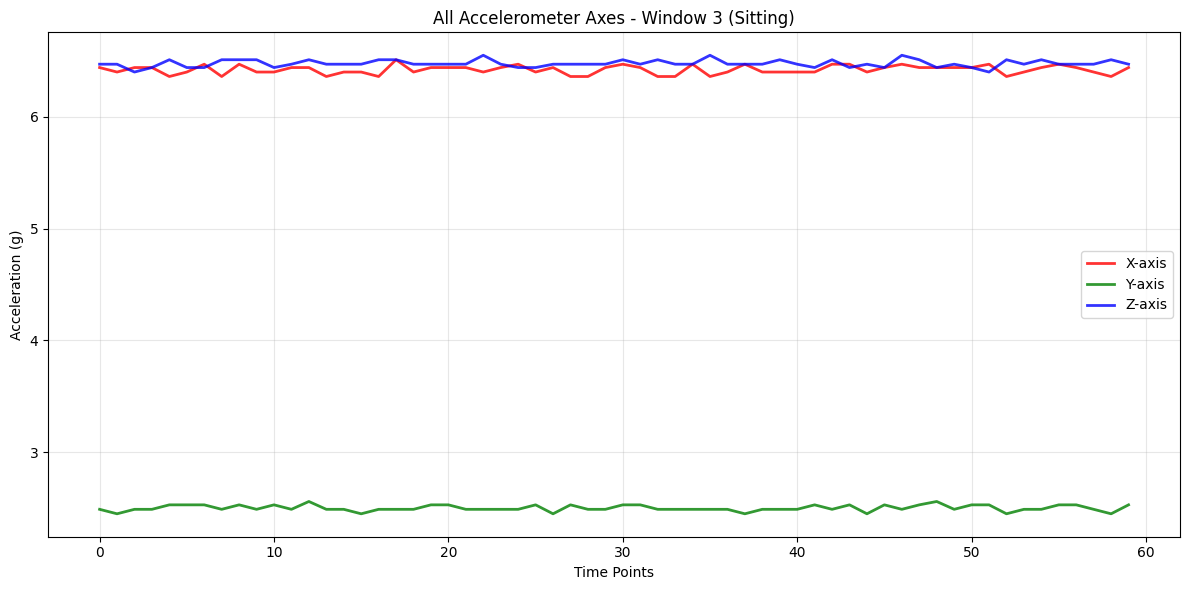

WINDOW 4/5
User: 12
Time: 82.5s - 85.5s
Activity: Sitting (Ground Truth)

GROUND TRUTH CONCEPTS:
   Periodicity: 0.0
   Temporal Stability: 1.0
   Coordination: 1.0
   Movement Variability: 0.0000
   Movement Consistency: 0.5000

CNN PREDICTED CONCEPTS:
   Periodicity: 0.0 (confidence: 0.991)
   Temporal Stability: 1.0 (confidence: 0.994)
   Coordination: 1.0 (confidence: 0.999)
   Movement Variability: 0.0 (confidence: 0.999)
   Movement Consistency: 0.5 (confidence: 0.936)
LOGISTIC REGRESSION PREDICTIONS:
   Correct label for this window: Sitting
   CNN→LR: Sitting (confidence: 0.426)
   GT→LR: Sitting (confidence: 0.426)

TOP 3 ACTIVITY CLOSEST ACTIVITIES:
   1. Sitting: 0.426
   2. Standing: 0.418
   3. Downstairs: 0.067


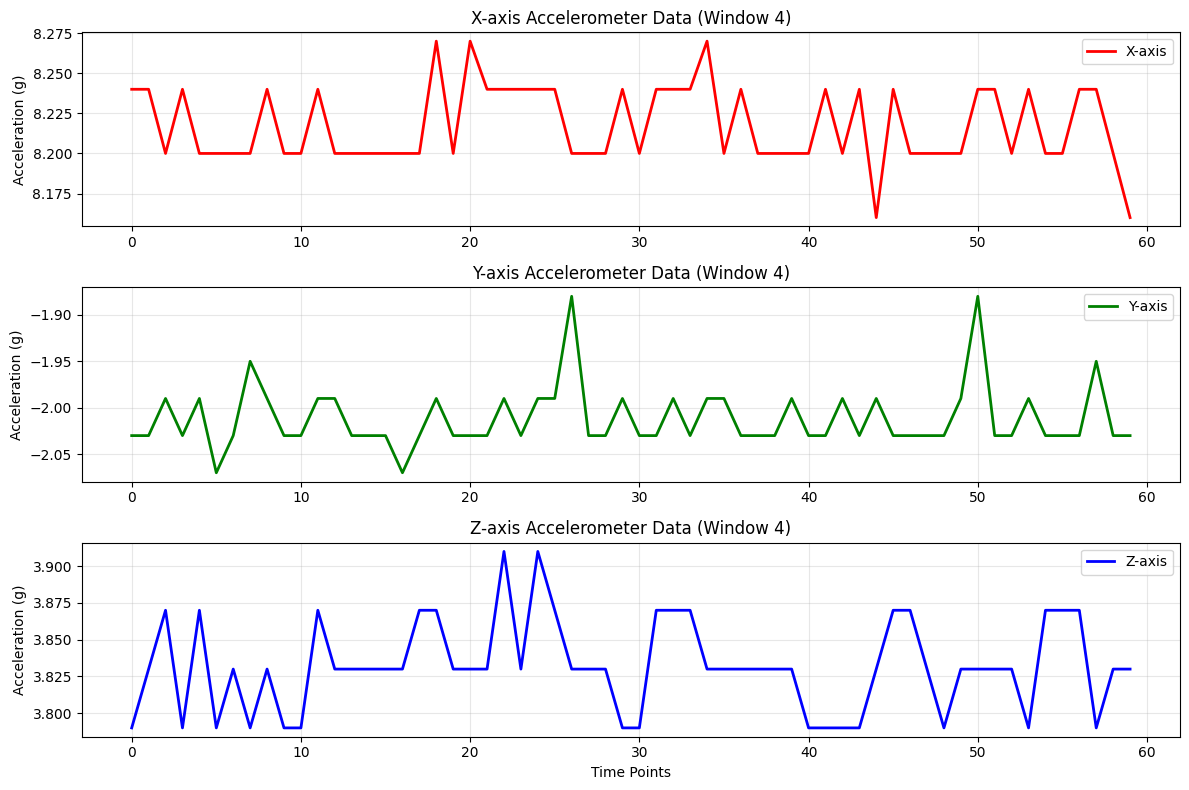

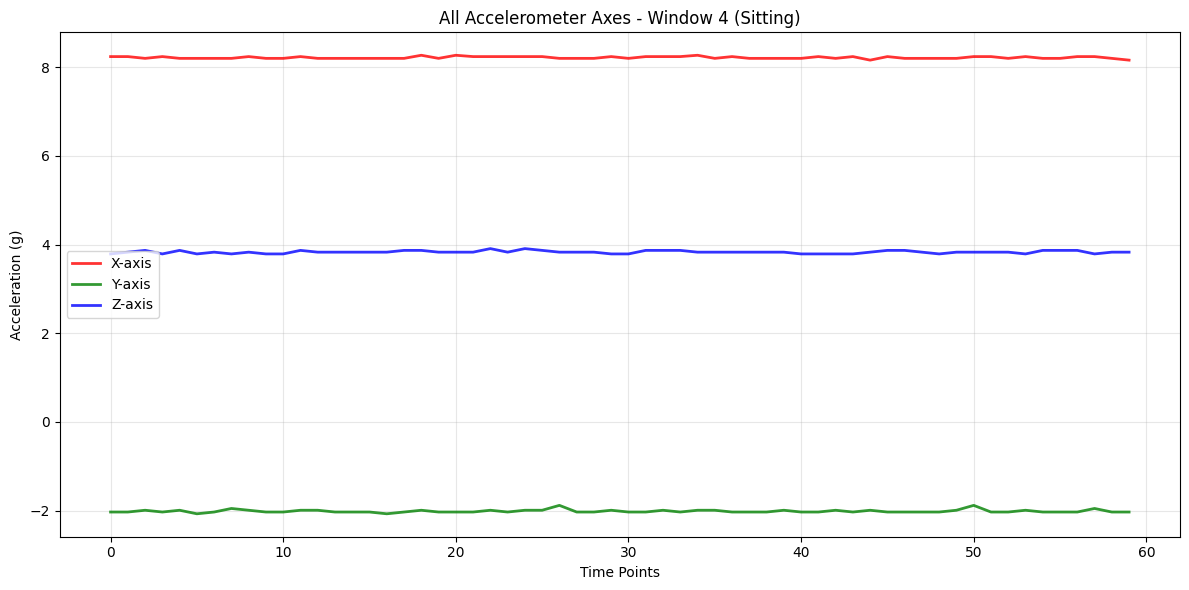

WINDOW 5/5
User: 7
Time: 798.8s - 801.8s
Activity: Jogging (Ground Truth)

GROUND TRUTH CONCEPTS:
   Periodicity: 1.0
   Temporal Stability: 1.0
   Coordination: 0.5
   Movement Variability: 1.0000
   Movement Consistency: 1.0000

CNN PREDICTED CONCEPTS:
   Periodicity: 1.0 (confidence: 0.755)
   Temporal Stability: 0.5 (confidence: 0.709)
   Coordination: 0.5 (confidence: 0.796)
   Movement Variability: 1.0 (confidence: 0.971)
   Movement Consistency: 1.0 (confidence: 0.945)
LOGISTIC REGRESSION PREDICTIONS:
   Correct label for this window: Jogging
   CNN→LR: Jogging (confidence: 0.640)
   GT→LR: Jogging (confidence: 0.727)

TOP 3 ACTIVITY CLOSEST ACTIVITIES:
   1. Jogging: 0.640
   2. Walking: 0.218
   3. Downstairs: 0.091


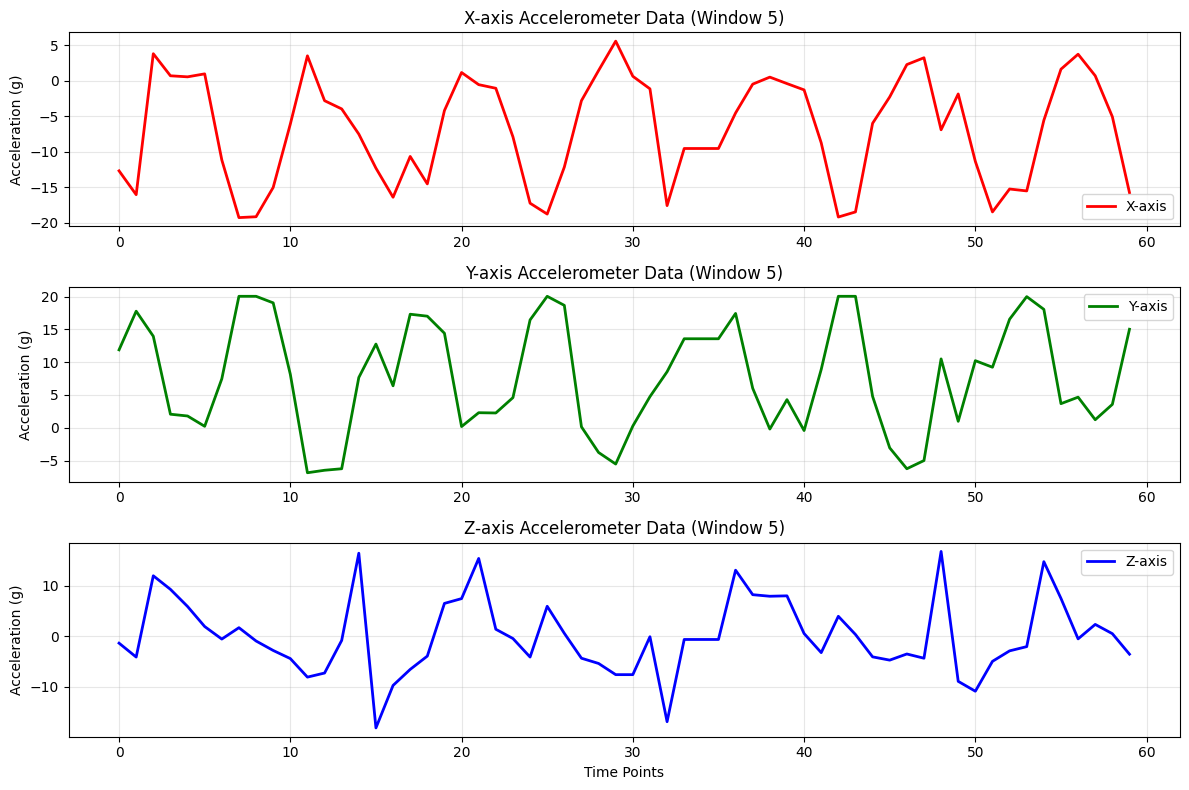

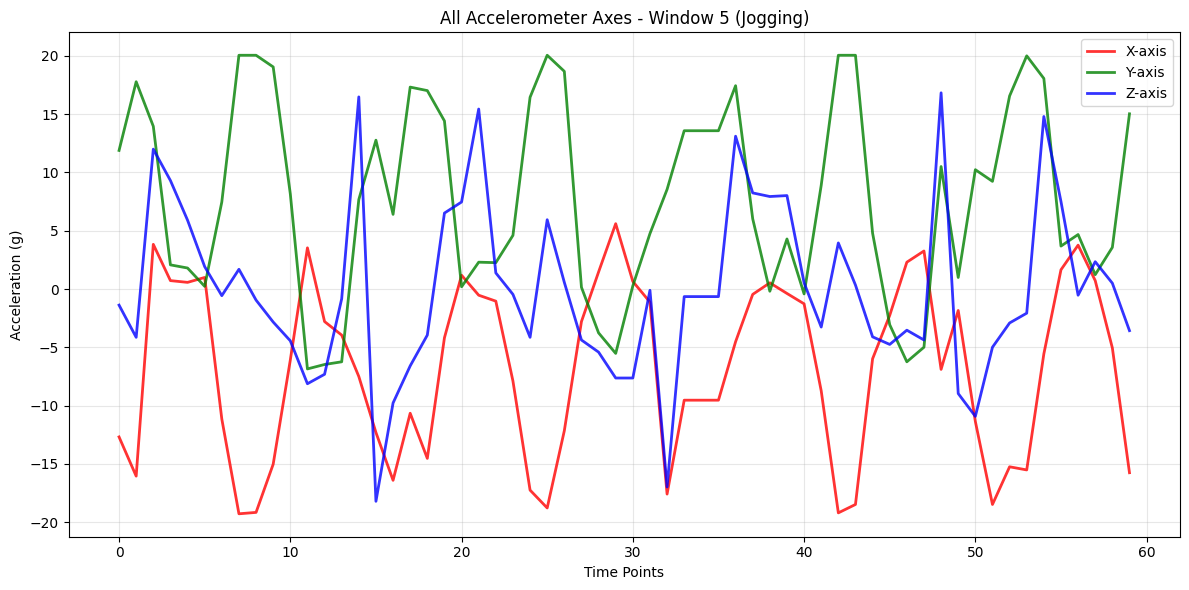

In [25]:
NUMBER_OF_WINDOWS_TO_LOOK_AT = 5 # change as needed


n_windows_to_analyze = min(NUMBER_OF_WINDOWS_TO_LOOK_AT, len(X_test_filtered))
reverse_activity_mapping = {v: k for k, v in activity_mapping.items()}


for i in range(n_windows_to_analyze):
    print(f"\033[31mWINDOW {i+1}/{n_windows_to_analyze}\033[0m")
    
    row = rows_filtered[i]
    print(f"User: {row['user']}")
    print(f"Time: {row['start_time']:.1f}s - {row['end_time']:.1f}s")
    print(f"Activity: {row['activity']} (Ground Truth)")
    
    print(f"\nGROUND TRUTH CONCEPTS:")
    print(f"   Periodicity: {row['periodicity']}")
    print(f"   Temporal Stability: {row['temporal_stability']}")
    print(f"   Coordination: {row['coordination']}")
    print(f"   Movement Variability: {row['movement_variability']:.4f}")
    print(f"   Movement Consistency: {row['movement_consistency']:.4f}")
    
    print(f"\nCNN PREDICTED CONCEPTS:")
    print(f"   Periodicity: {periodicity_pred[i] / 2} (confidence: {np.max(predictions[0][i]):.3f})")
    print(f"   Temporal Stability: {temporal_stability_pred[i] / 2} (confidence: {np.max(predictions[1][i]):.3f})")
    print(f"   Coordination: {coordination_pred[i] / 2} (confidence: {np.max(predictions[2][i]):.3f})")
    print(f"   Movement Variability: {movement_variability_pred[i] / 2} (confidence: {np.max(predictions[3][i]):.3f})")
    print(f"   Movement Consistency: {movement_consistency_pred[i] / 2} (confidence: {np.max(predictions[4][i]):.3f})")
    
    print("\033[1;34m" + "=" * 50 + "\033[0m")
    
    gt_activity = row['activity']
    predicted_activity_cnn_lr = reverse_activity_mapping[y_pred_lr_cnn[i]]
    predicted_activity_gt_lr = reverse_activity_mapping[y_pred_lr_gt_original[i]]
    

    print(f"LOGISTIC REGRESSION PREDICTIONS:")
    print(f"   Correct label for this window: {gt_activity}")
    print(f"   CNN→LR: {predicted_activity_cnn_lr} (confidence: {np.max(y_pred_proba_lr_cnn[i]):.3f})")
    print(f"   GT→LR: {predicted_activity_gt_lr} (confidence: {np.max(y_pred_proba_lr_gt_original[i]):.3f})")
    
    cnn_lr_correct = (y_pred_lr_cnn[i] == y_test_original[i])
    gt_lr_correct = (y_pred_lr_gt_original[i] == y_test_original[i])

    top3_indices = np.argsort(y_pred_proba_lr_cnn[i])[-3:][::-1]
    print(f"\nTOP 3 ACTIVITY CLOSEST ACTIVITIES:")
    for j, idx in enumerate(top3_indices):
        activity_name = reverse_activity_mapping[idx]
        prob = y_pred_proba_lr_cnn[i][idx]
        print(f"   {j+1}. {activity_name}: {prob:.3f}")
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))
    
    window_data = X_test_filtered[i]
    time_points = np.arange(len(window_data))
    
    axes[0].plot(time_points, window_data[:, 0], 'r-', linewidth=2, label='X-axis')
    axes[0].set_title(f'X-axis Accelerometer Data (Window {i+1})')
    axes[0].set_ylabel('Acceleration (g)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    axes[1].plot(time_points, window_data[:, 1], 'g-', linewidth=2, label='Y-axis')
    axes[1].set_title(f'Y-axis Accelerometer Data (Window {i+1})')
    axes[1].set_ylabel('Acceleration (g)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    axes[2].plot(time_points, window_data[:, 2], 'b-', linewidth=2, label='Z-axis')
    axes[2].set_title(f'Z-axis Accelerometer Data (Window {i+1})')
    axes[2].set_xlabel('Time Points')
    axes[2].set_ylabel('Acceleration (g)')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, window_data[:, 0], 'r-', linewidth=2, label='X-axis', alpha=0.8)
    plt.plot(time_points, window_data[:, 1], 'g-', linewidth=2, label='Y-axis', alpha=0.8)
    plt.plot(time_points, window_data[:, 2], 'b-', linewidth=2, label='Z-axis', alpha=0.8)
    plt.title(f'All Accelerometer Axes - Window {i+1} ({row["activity"]})')
    plt.xlabel('Time Points')
    plt.ylabel('Acceleration (g)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()